In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
import statsmodels as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import optuna.integration.lightgbm as lgb
from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_absolute_percentage_error
import japanize_matplotlib
import seaborn as sns

In [13]:
def root_mean_squared_error(y_pred, y_test):
    return mean_squared_error(y_pred, y_test)**(1/2)

In [14]:
df_raw = pd.read_csv("../data/kk.csv")
# 全体のみを利用(産地名NaN)
is_nan = [df_raw["産地名"][i] is df_raw["産地名"][0] for i in range(df_raw.shape[0])]
df = df_raw[is_nan].copy()
del_columns = ["産地名", "産地コード", "品目名", "品目コード", "対前日比（数量）", "対前日比（価格）"]
df = df.drop(del_columns, axis=1).copy()

# 特異日の処理
# outlier = df[df["価格"].max() == df["価格"]].index 
# df = df.drop(outlier, axis=0).copy()

In [15]:
df[df["価格"]==df["価格"].max()]

,年,月,日,曜日,数量,価格
10597,2019,10,22,火,20,5816


In [16]:
df_raw.iloc[10590:10610]

,年,月,日,曜日,品目名,品目コード,産地名,産地コード,数量,価格,対前日比（数量）,対前日比（価格）
10590,2019,10,19,土,いちご,46100,秋 田,5.0,182,1834,NaN,NaN
10591,2019,10,21,月,いちご,46100,NaN,NaN,3129,2565,116.3,105.5
10592,2019,10,21,月,いちご,46100,北海道,1.0,849,2399,NaN,NaN
10593,2019,10,21,月,いちご,46100,長 野,20.0,495,2588,NaN,NaN
10594,2019,10,21,月,いちご,46100,栃 木,9.0,325,3082,NaN,NaN
10595,2019,10,21,月,いちご,46100,山 形,6.0,281,2075,NaN,NaN
10596,2019,10,21,月,いちご,46100,青 森,2.0,257,2407,NaN,NaN
10597,2019,10,22,火,いちご,46100,NaN,NaN,20,5816,0.6,226.7
10598,2019,10,22,火,いちご,46100,佐 賀,41.0,20,5816,NaN,NaN
10599,2019,10,23,水,いちご,46100,NaN,NaN,4355,2492,******,42.8


In [17]:
# 曜日の処理
dow = ["月", "火", "水", "木", "金", "土", "日"]
df["曜日"] = [dow.index(dw) for dw in df["曜日"]]

In [18]:
# 日にちの処理
# timestamp型 → timedelta
date_columns = ["年", "月", "日"]
date = [str(df["年"].iloc[i])+"-"+str(df["月"].iloc[i])+"-"+str(df["日"].iloc[i]) for i in range(df.shape[0])]
df["date"] = pd.to_datetime(date)
df = df.drop(date_columns, axis=1).copy()
df["days"] = [(date - df["date"][0]).days for date in df["date"]]
df = df.drop("date", axis=1).copy()


In [19]:
df

,曜日,数量,価格,days
0,3,840793,1525,0
4,4,528012,1377,1
8,5,317676,1292,2
12,0,667,1466,4
15,1,549611,1234,5
...,...,...,...,...
13463,1,3786,2521,3561
13466,3,5602,2491,3563
13470,4,2980,2165,3564
13474,5,3349,2347,3565


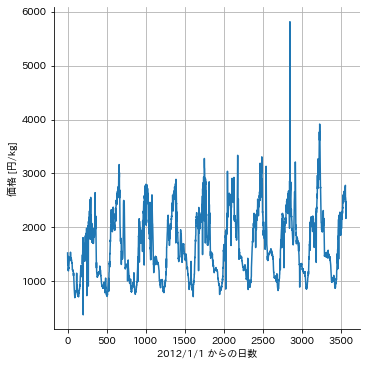

In [20]:
# 可視化
sns.relplot(x=df["days"], y=df["価格"], kind='line')
plt.xlabel("2012/1/1 からの日数")
plt.ylabel("価格 [円/kg]")
plt.grid()

In [10]:
# # scaling
# scaling_columns = ["価格"]
# scaler = StandardScaler()
# df = df.copy()
# df[scaling_columns] = scaler.fit_transform(df[scaling_columns])


In [11]:
# train-test-split
# 7年分をtrain，3年分をtest(index 9426以上)
df_train = df[df.index < 9426].copy()
df_test = df[df.index >= 9426].copy()


In [12]:
n_train = df_train.shape[0] - 7 - 6
X_train_idx = [np.array([0,1,2,3,4,5,6]) + i for i in range(n_train)]
y_train_idx = [i + 7 + 6 for i in range(n_train)]


In [13]:
n_test = df_test.shape[0] - 7 - 6
X_test_idx = [np.array([0, 1, 2, 3, 4, 5, 6]) + i for i in range(n_test)]
y_test_idx = [i + 7 + 6 for i in range(n_test)]


In [14]:
X_train = np.array([df_train["価格"].iloc[xt_i].values for xt_i in X_train_idx])
y_train = np.array([df_train["価格"].iloc[yt_i] for yt_i in y_train_idx])

X_test = np.array([df_test["価格"].iloc[xt_i].values for xt_i in X_test_idx])
y_test = np.array([df_test["価格"].iloc[yt_i] for yt_i in y_test_idx])


In [15]:
from sklearn.svm import SVR
model = SVR()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [16]:
score = root_mean_squared_error(y_pred, y_test)
print(score)

436.836622679821


Text(0.5, 1.0, '市場価格の予測')

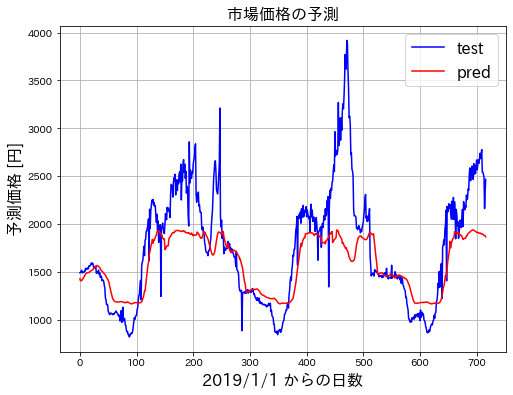

In [17]:
fig, ax = plt.subplots()
ax.grid()
fig.set_figwidth(8)
fig.set_figheight(6)

ax.plot(np.arange(y_test.shape[0]), y_test, "b", label="test")
ax.plot(np.arange(y_pred.shape[0]), y_pred, "r", label="pred")
ax.legend(fontsize=16)
ax.set_xlabel("2019/1/1 からの日数", fontsize=16)
ax.set_ylabel("予測価格 [円]", fontsize=16)
ax.set_title("市場価格の予測", fontsize=16)


Text(0.5, 0, 'day after 2019')

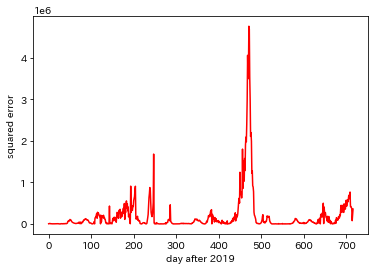

In [18]:
error = (y_pred - y_test)**2
fig, ax = plt.subplots()
ax.plot(np.arange(y_pred.shape[0]), error, "r")
ax.set_ylabel("squared error")
ax.set_xlabel("day after 2019")


In [19]:
ape = sum(abs((y_test-y_pred)/y_test))
mape = ape/y_test.shape
print(mape)

[0.15678114]


In [100]:
df_raw

,年,月,日,曜日,品目名,品目コード,産地名,産地コード,数量,価格,対前日比（数量）,対前日比（価格）
0,2012,1,5,木,いちご,46100,NaN,NaN,840793,1525,1360.9,74.1
1,2012,1,5,木,いちご,46100,栃 木,9.0,169472,1273,NaN,NaN
2,2012,1,5,木,いちご,46100,福 岡,40.0,163334,1824,NaN,NaN
3,2012,1,5,木,いちご,46100,愛 知,23.0,98791,1489,NaN,NaN
4,2012,1,6,金,いちご,46100,NaN,NaN,528012,1377,62.8,90.3
...,...,...,...,...,...,...,...,...,...,...,...,...
13479,2021,10,11,月,いちご,46100,NaN,NaN,4053,2469,121.0,105.2
13480,2021,10,11,月,いちご,46100,北海道,1.0,1605,2476,NaN,NaN
13481,2021,10,11,月,いちご,46100,長 野,20.0,1063,2459,NaN,NaN
13482,2021,10,11,月,いちご,46100,青 森,2.0,408,1961,NaN,NaN


In [21]:
import lightgbm as lgb_o

model = lgb_o.LGBMRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

score = root_mean_squared_error(y_pred, y_test)
print(score)

ape = sum(abs((y_test-y_pred)/y_test))
mape = ape/y_test.shape
print(mape[0])

272.0733014390999
0.09407889261253585


Text(0.5, 1.0, '市場価格の予測')

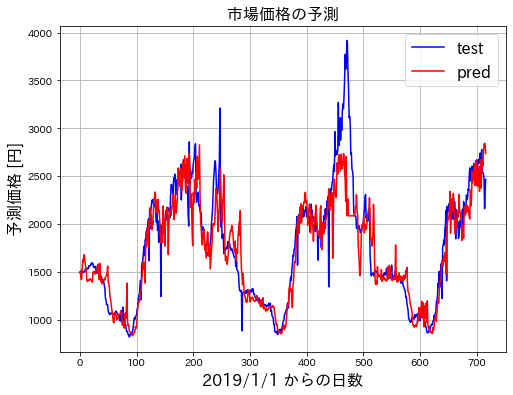

In [22]:
fig, ax = plt.subplots()
ax.grid()
fig.set_figwidth(8)
fig.set_figheight(6)

ax.plot(np.arange(y_test.shape[0]), y_test, "b", label="test")
ax.plot(np.arange(y_pred.shape[0]), y_pred, "r", label="pred")
ax.legend(fontsize=16)
ax.set_xlabel("2019/1/1 からの日数", fontsize=16)
ax.set_ylabel("予測価格 [円]", fontsize=16)
ax.set_title("市場価格の予測", fontsize=16)


Text(0.5, 0, 'day after 2019')

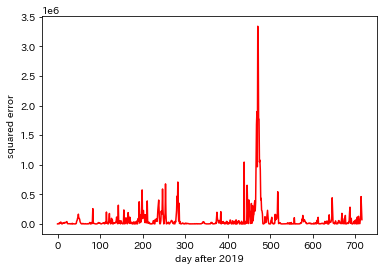

In [23]:
error = (y_pred - y_test)**2
fig, ax = plt.subplots()
ax.plot(np.arange(y_pred.shape[0]), error, "r")
ax.set_ylabel("squared error")
ax.set_xlabel("day after 2019")

# Optuna 利用

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

# ベストなパラメータ、途中経過を保存する
params = {
    'objective': 'regression',
    'metric': 'mape',
    "verbosity": -1,
    "boosting_type": "gbdt",
}

best_params, history = {}, []

# LightGBM学習
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=[lgb_train, lgb_eval],
                early_stopping_rounds=50
               )

best_params = gbm.params
best_params

In [ ]:
y_pred=gbm.predict(X_test, num_iteration=gbm.best_iteration)
score = root_mean_squared_error(y_pred, y_test)
print(score)

ape = sum(abs((y_test-y_pred)/y_test))
mape = ape/y_test.shape
print(mape)

In [ ]:
fig, ax = plt.subplots()
plt.figure(figsize=(6, 8))

ax.grid()

ax.plot(np.arange(y_test.shape[0]), y_test, "b", label="test")
ax.plot(np.arange(y_pred.shape[0]), y_pred, "r", label="pred")
ax.legend()
ax.set_xlabel("days")
ax.set_ylabel("price [yen]")
ax.set_title("LGBM+Optuna")
